# Training a CNN network to classify brain tumors based on MRI images
In this notebook I train a Resnet 18 CNN network to classify 3 types of brain tumors. For more details on the network architecture and on the dataset used please check the model card and dataset datasheet, repectively.

I trained the CNN classifier using a range of dropout fractions for later assessment of CNN accuracy and certainty estimation performance, in the Certainty_estimators notebook.

In [1]:
# Install required packages
!pip install h5py
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 15.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.8 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
work_path = "/dss/dsshome1/lxc0B/di29let/ondemand/Projects/Repositories/certainty-estimator"
import sys
sys.path.append(work_path)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from utils.datasets import MRI_dataset_random
from torch.utils.data import random_split
from torchvision import transforms
import os
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dev = torch.device("cuda:0")

## Instantiate the dataset
In order to make the CNN more robust to image corruption (e. g. by undersampling) and decrease overfitting, I used a series of transformations for data augmentation, namely flipping, translations, rotations, scaling and masking.

The custom dataset class randomly picks images stored in the dataset path in a way that balances the 3 classes.

In [10]:
dataset_path = "/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/MRI_dataset_2/"

# Load file with labels
with h5.File(os.path.join(dataset_path,'labels.h5'),'r') as label_file:
    labels = torch.tensor(label_file['label'])

# Load indices of small images to exclude
inds_small = np.load(os.path.join(dataset_path,'small_images_inds.npy'))
inds_all = np.setdiff1d(np.arange(1,labels.size()[0]),np.where(inds_small)[0])

# Split dataset indices into two subsets used for training and validation
inds_datasets = random_split(inds_all,[0.6,0.4],generator=torch.Generator().manual_seed(42))


# Define a function to mask the image
def random_zero_mask(image, dev, fraction):
    """
    Create a random mask where a fraction of pixels are set to zero.

    Args:
        image (torch.Tensor): Input image tensor with shape (height, width).
        fraction (float): Fraction of pixels to set to zero.

    Returns:
        torch.Tensor: Random mask tensor with the same shape as the input image.
    """
    # Define the mask template, in this case a 1/32 of the image size results in a 16x16 template
    reduction = 32
    mask = torch.rand((int(512/reduction),int(512/reduction)),device=dev) < fraction
    mask = torch.where(mask,0,1)

    # Define resizing transform to convert the tamplate to the original image size
    resize_transform = transforms.Resize((512,512),interpolation=transforms.InterpolationMode.NEAREST_EXACT,antialias=False)

    mask = resize_transform(mask.unsqueeze(0))
    masked_image = image * mask

    return masked_image

def mask_transform(max_fraction):
    """
    Create a transformation that applies a random zero mask with a fraction of pixels set to zero.

    Args:
        max_fraction (float): Maximum fraction of pixels that can be set to zero.

    Returns:
        transforms.Lambda: A transformation that applies the random zero mask to an image.
    """
    
    fraction = torch.rand((1,),device=dev)*max_fraction
    mask = transforms.Lambda(lambda x: random_zero_mask(x, dev, fraction))
    
    return mask

# Create the mask transform
add_mask_transform = mask_transform(0.98)

# Define the transformation pipeline for the training dataset
translation=(0.1, 0.1)
scales=(0.9, 1.05)
degrees=(-10, 10)

# No transformation for validation dataset
transform_validation = transforms.Compose([])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0,translate=translation),
    transforms.RandomAffine(degrees=0,scale=scales),
    transforms.RandomAffine(degrees=degrees),
    add_mask_transform
])

# Create an instance of the MRIDataset with transforms applied only on the training set
transformations = [transform, transform_validation]
datasets = []
for i in range(2):
    datasets.append(
        MRI_dataset_random(dataset_path, torch.tensor(inds_datasets[i]), dev,transforms=transformations[i])
    )

Let's take a look at some examples from each dataset belonging to each class.

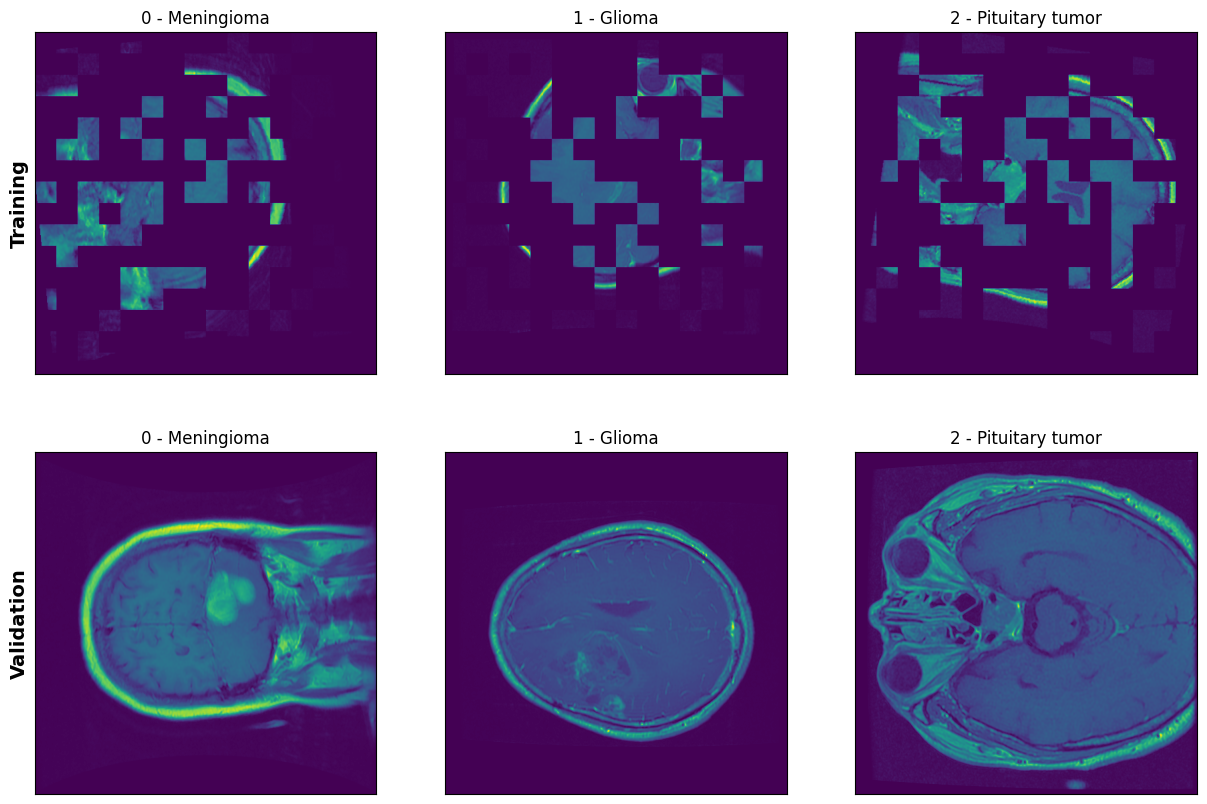

In [40]:
fig, ax = plt.subplots(2,3,figsize=(15,10))

label_names = ['Meningioma', 'Glioma', 'Pituitary tumor']
dataset_names = ['Training', 'Validation']
exloader = []
for dataset in datasets: 
    exloader.append(iter(DataLoader(dataset,batch_size=1)))

for p,loader in enumerate(exloader):                     
    for i,label_name in enumerate(label_names):
        for sample in loader:
            if sample[1]==i:
                ax[p,i].imshow(sample[0].squeeze().cpu())
                ax[p,i].set(title=f"{int(sample[1])} - {label_names[sample[1]]}",xticks=[],yticks=[])
                if i==0:
                    ax[p,i].set_ylabel(dataset_names[p],fontsize=14, fontweight='bold')
                break
plt.show()

## Train the CNN network
Next I define a function to train the CNN.

In [50]:
import time

def trainNet(net, data_train, optimizer,criterion, batch_size=4, epochs=4, printr=False, save_loss=False):
    """
    Trains a neural network on the given dataset.

    Args:
        net (torch.nn.Module): The neural network model to train.
        data_train (torch.utils.data.Dataset): The training dataset.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        criterion (torch.nn.Module): The loss function.
        batch_size (int, optional): The number of samples per batch. Default is 4.
        epochs (int, optional): The number of epochs to train for. Default is 4.
        printr (bool, optional): Whether to print the running loss during training. Default is False.
        save_loss (bool, optional): Whether to save and return the loss for each mini-batch. Default is False.

    Returns:
        list: A list of loss values if save_loss is True, otherwise None.

    Notes:
        - The function trains the model for the specified number of epochs, updates the model weights using 
          backpropagation, and clips gradients to avoid exploding gradients.
        - Optionally, it prints the loss every 10 mini-batches and tracks the training time.
    """
    
    # Set the model to training mode
    net.train()
    
    # Create data loader object
    loader = DataLoader(data_train,batch_size=batch_size, shuffle=True,drop_last=True)

    start = time.time()
    epoch_start = 0
    rloss = []
    
    
    for epoch in range(epochs):  

        epoch_start += 1
        running_loss = 0.0

        for i, (image,target,_) in enumerate(loader):

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Compute network output
            outputs=net(image)
            
            # Calculate loss
            loss = criterion(outputs, target)
        
            # Update weights based on backpropagation
            loss.backward()
            
            # Clip to avoid exploding gradients
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
            
            # Update optimizer
            optimizer.step()

            # Output
            if save_loss:
                rloss.append(loss.item())

            if printr:
                # Print statistics
                running_loss += loss.item()

                if (i+1) % 10 == 0:    # print every 10 mini-batches
                    print(f"[{epoch+1}, {i+1}] loss: {np.round(running_loss/(10),7)}")

                    running_loss = 0.0

    end = time.time()

    if printr:
        print('Finished Training')
        print('training time ', end-start)

    if save_loss:
        return rloss

Next, I define a set of functions to test the CNN performance and load model checkpoints

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [53]:
def test(net, data, criterion, dropout_p, batch_size=10, printr=False):
    """
    Test the neural network predictions on a given dataset.

    Args:
        net (torch.nn.Module): The neural network model to test.
        data (torch.utils.data.Dataset): The dataset on which to test the model.
        criterion (torch.nn.Module): The loss function.
        dropout_p (float): The dropout probability to restore after testing.
        batch_size (int, optional): The size of batches for testing. Default is 10.
        printr (bool, optional): Whether to print performance results. Default is False.

    Returns:
        tuple: A tuple containing:
            - cm (numpy.ndarray): The confusion matrix for the first batch.
            - accuracy (float): The accuracy of the model on the dataset.
            - predicted (list): List of predicted labels for the dataset.
            - labels (list): List of true labels for the dataset.
            - losses (list): List of loss values for each batch during testing.

    Notes:
        - This function sets the model's dropout probability to 0 during testing.
        - It computes accuracy, confusion matrix, and losses over the dataset.
        - After testing, the dropout probability is restored to its original value.
    """

    # Instantiate the data loader and disable dropout
    testloader = iter(DataLoader(data,batch_size=batch_size))
    net.dropout.p = 0
    net.to(torch.device(dev))
    
    correct = 0
    total = 0
    labels = []
    predicted = []
    losses = []
    
    # Disable gradient calculations during testing
    with torch.no_grad():
        for _ in range(10):
            
            image,label,_ = next(testloader)
            
            # Compute predictions from the class with max output
            outputs=net(image).cpu()
            prediction = np.argmax(outputs,axis=1)
            
            # Update counts for accuracy calculation
            total += label.size(0)
            correct += (prediction == label.cpu()).sum().item()
            
            # Store true labels and predictions
            labels.append(list(label.cpu()))
            predicted.append(list(prediction))
            
            # Compute loss and store it
            loss = criterion(outputs,label.cpu()).item()
            losses.append(loss)
    
    # Compute confusion matrix for the first batch
    cm = confusion_matrix(labels[0],predicted[0])
    
    if printr:
        print(cm)
        print('Accuracy:', 100*correct/total)
    
    # Restore the original dropout probability
    net.dropout.p = dropout_p
    
    return cm, 100*correct/total, predicted, labels, losses

In [44]:
def SaveCheckpoint(path,bsize,lr,beta1,beta2,epocs):
    torch.save({
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'batch_size': bsize,
        'learning_rate': lr,
        'beta1': beta1,
        'beta2': beta2,
        'epochs': epocs
    },path)

In [47]:
from utils.models import UncertaintyResNetPretrained

def load_model(path,dropout_rate):
    """
    Load a pre-trained model along with its learning parameters.

    Args:
        path (str): The file path to the saved model checkpoint.
        dropout_rate (float): The dropout rate to use in the model.

    Returns:
        net (torch.nn.Module): The loaded neural network model.
        learning_params (dict): A dictionary containing the model's learning parameters such as:
            - learning_rate (float)
            - batch_size (int)
            - beta1 (float)
            - beta2 (float)
            - epochs (int)
    """
    
    # Load the saved model checkpoint from the specified path
    model_dict = torch.load(path,map_location=dev)
    
    # Extract the model state dictionary
    state_dict = model_dict['model_state_dict']
    
    # Initialize the model architecture with the specified dropout rate
    net = UncertaintyResNetPretrained(num_classes=3,dropout_rate=dropout_rate,pretrained_weights=True)
    net.load_state_dict(state_dict,strict=False)
    net.to(dev)
    
    # Extract and return learning parameters
    learning_params = {key: model_dict[key] for key in ['learning_rate','batch_size','beta1','beta2','epochs']}
    
    return net, learning_params

Now we can train the model with a given dropout rate. I use cross-entropy loss as the loss function and Adam optimizer with preset learning rates. Training is run for 20 epochs with a batch size of 16.

In [48]:
#create CNN object
import torch.nn as nn
import torch.optim as optim
import tqdm

# Define loss function
criterion = nn.CrossEntropyLoss()

In [ ]:

bsize = 16
epoc = 1
dropout_p = 0
model_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_0_nonorm_masked_extendedtrain06/29_05_2024'

if not os.path.isdir(model_path):
    os.makedirs(model_path)

net = UncertaintyResNetPretrained(num_classes=3,dropout_rate=dropout_p,pretrained_weights=True)
net = net.to(dev)

learn_params = {key: [] for key in ['learning_rate','beta1','beta2']}

lrs = np.concatenate((np.tile(1e-4,10),np.tile(1e-5,10)))

# Alternatively, continue training from a model checkpoint
#net, learn_params = load_model(os.path.join(model_path,'resnet18_epoc_10'),dropout_p)


for i in np.arange(20):
    #lr = 1e-5
    lr = lrs[i]
    beta1 = 0.95
    beta2 = 0.999
    epocs = int(epoc*(i+1))
    
    #create optimizer
    optimizer = optim.Adam(net.parameters(),lr=lr,betas=(beta1,beta2))
    
    learn_params['learning_rate'].append(lr)
    learn_params['beta1'].append(beta1)
    learn_params['beta2'].append(beta2)
    
    # Train
    loss_nlayers = trainNet(net,datasets[0],optimizer,criterion,batch_size=bsize,epochs=epoc,printr=True,save_loss=False)
    _, accuracy_train, _, _, loss_train = test(net,datasets[0],criterion,dropout_p,batch_size=bsize,printr=False)
    print(f"Accuracy in the training set: {accuracy_train}, loss: {np.mean(loss_train)}")
    
    _, accuracy_val, _, _, loss_val = test(net,datasets[1],criterion,dropout_p,batch_size=bsize,printr=False)
    print(f"Accuracy in the validation set: {accuracy_val}, loss: {np.mean(loss_val)}")
    
    #SaveCheckpoint(os.path.join(model_path,f"resnet18_epoc_{epocs}"),bsize,learn_params['learning_rate'],learn_params['beta1'],learn_params['beta2'],epocs)

## Check model checkpoint performance
To get a better idea on how performance is improving accross training epochs I compute the accuracy and loss accross model checkpoints.

In [56]:
#load checkpoints and compute accuracy
performance = {}
meas_names = ['accuracies','losses']
dataset_names = ['Train','Val']
epocs=20
model_path = '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_0_nonorm_masked_extendedtrain06/29_05_2024'


for meas in meas_names:
    performance[meas] = {}
    for name in dataset_names:
        performance[meas][name] = {}

for epoc_nr in range(1,int(epocs)+1,1):
    check_path = os.path.join(model_path,f"resnet18_epoc_{epoc_nr}")
    net, _ = load_model(check_path,dropout_rate=dropout_p)
    print(f"Calculating accuracies for model at epoch {epoc_nr}")
    
    accs = []
    loss = []
    for i in tqdm.trange(20,desc='Training set'):
        _, acc, _, _, los = test(net,datasets[0],criterion,dropout_p,batch_size=16,printr=False)
        accs.append(acc)
        loss.append(los)
    performance['accuracies']['Train'][epoc_nr] = np.array(accs)
    performance['losses']['Train'][epoc_nr] = np.array(loss)
    
    accs = []
    loss = []
    for i in tqdm.trange(20,desc='Validation set'):
        _, acc, _, _, los = test(net,datasets[1],criterion,dropout_p,batch_size=16,printr=False)
        accs.append(acc)
        loss.append(los)
    performance['accuracies']['Val'][epoc_nr] = np.array(accs)
    performance['losses']['Val'][epoc_nr] = np.array(loss)

Calculating accuracies for model at epoch 1


Validation set: 100%|██████████| 20/20 [01:09<00:00,  3.45s/it]


Calculating accuracies for model at epoch 2


Validation set: 100%|██████████| 20/20 [00:43<00:00,  2.20s/it]


Calculating accuracies for model at epoch 3


Validation set: 100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


Calculating accuracies for model at epoch 4


Validation set: 100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


Calculating accuracies for model at epoch 5


Validation set: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it]


Calculating accuracies for model at epoch 6


Validation set: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


Calculating accuracies for model at epoch 7


Validation set: 100%|██████████| 20/20 [00:41<00:00,  2.05s/it]


Calculating accuracies for model at epoch 8


Validation set: 100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


Calculating accuracies for model at epoch 9


Validation set: 100%|██████████| 20/20 [00:39<00:00,  1.99s/it]


Calculating accuracies for model at epoch 10


Validation set: 100%|██████████| 20/20 [00:40<00:00,  2.02s/it]


Calculating accuracies for model at epoch 11


Validation set: 100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


Calculating accuracies for model at epoch 12


Validation set: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Calculating accuracies for model at epoch 13


Validation set: 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


Calculating accuracies for model at epoch 14


Validation set: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


Calculating accuracies for model at epoch 15


Validation set: 100%|██████████| 20/20 [00:39<00:00,  1.98s/it]


Calculating accuracies for model at epoch 16


Validation set: 100%|██████████| 20/20 [00:39<00:00,  1.95s/it]


Calculating accuracies for model at epoch 17


Validation set: 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


Calculating accuracies for model at epoch 18


Validation set: 100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


Calculating accuracies for model at epoch 19


Validation set: 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


Calculating accuracies for model at epoch 20


Validation set: 100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


In [57]:
#save dictionary
torch.save(performance,os.path.join(model_path,'performance.pth'))

In [55]:
performance = torch.load(os.path.join(model_path,'performance.pth'))

FileNotFoundError: [Errno 2] No such file or directory: '/dss/dssfs02/lwp-dss-0001/pr84qa/pr84qa-dss-0000/ricardo/data/Projects/MRI_classification/models/resnet18/pretrained/dropout_allconvs/dp_rate_0_nonorm_masked_extendedtrain06/29_05_2024/performance.pth'

In [27]:
model_dict = torch.load(os.path.join(model_path,'resnet18_epoc_1'),map_location=dev)

In [58]:
import scipy.stats as stats

stats_model = {}
for meas in meas_names:
    stats_model[meas] = {}
    for name in dataset_names:
        stats_model[meas][name] = {}
        stats_model[meas][name]['Mean'] = []
        stats_model[meas][name]['CI'] = []
                
for epoc_nr in np.arange(1,epocs+1,1):
    for meas in meas_names:
        for name in dataset_names:
            ndims = np.ndim(performance[meas][name][epoc_nr])
            n_freedom = performance[meas][name][epoc_nr].shape[0]-1
            if meas == 'losses':
                data = np.mean(performance[meas][name][epoc_nr],axis=1)
            else:
                data = performance[meas][name][epoc_nr]
            #print(data)
            mean_tm = np.mean(data)
            stats_model[meas][name]['Mean'].append(mean_tm)
            cint = stats.t.interval(0.95,n_freedom,loc=0,scale=stats.sem(data))
            stats_model[meas][name]['CI'].append(cint[1])

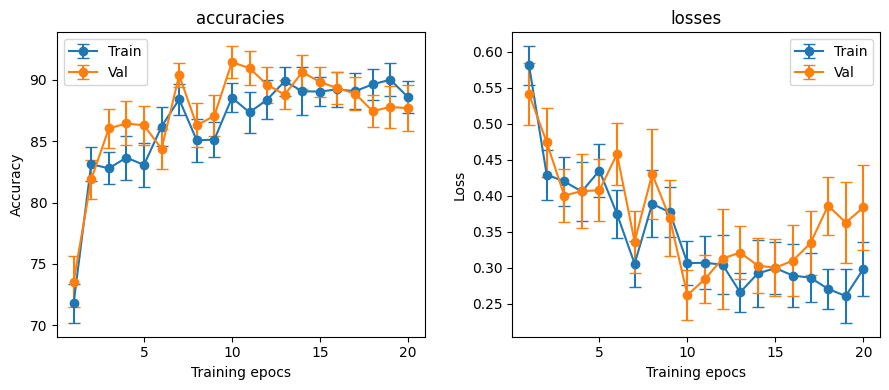

In [59]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
parameter = ['Accuracy','Loss']

for i,meas in enumerate(meas_names):
    for name in dataset_names:
        ax[i].errorbar(np.arange(1,epocs+1,1),stats_model[meas][name]['Mean'],yerr=stats_model[meas][name]['CI'],
                       marker='o',capsize=4)
    ax[i].legend(dataset_names)
    ax[i].set(title=meas,xlabel='Training epocs',ylabel=parameter[i])
    
plt.tight_layout(w_pad=2)
plt.show()

## Conclusion
Overall, the CNN networks could reach good accuracy after 20 epocs of training without overfitting. I conducted further CNN classifier performance tests in the Certainty_estimators notebook. 